# ieee-cis Fraud Detection
- 시각화를 제외한 데이터 전처리 / 모델링 부분 코드

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

#standard plotly imports
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode

#import cufflinks
import plotly.figure_factory as ff

#using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)

#preprocessing, modeling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
import xgboost as xgb

#hyperparameter optimization modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
print(os.listdir("../input"))

['df_id.pkl', 'df_test.pkl', 'df_train.pkl', 'df_trans.pkl', 'sample_submission.csv', 'test_identity.csv', 'test_transaction.csv', 'train_identity.csv', 'train_transaction.csv']


In [16]:
## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(
        end_mem, 100 * (start_mem - end_mem) / start_mem))
    
    return df

In [2]:
%%time
# df_trans.to_pickle("../input/df_trans.pkl")
# df_id.to_pickle("../input/df_id.pkl")
df_trans = pd.read_pickle("../input/df_trans.pkl")
df_id = pd.read_pickle("../input/df_id.pkl")
print("{:1.2f}Mb".format(df_trans.memory_usage().sum() / 1024**2)) #542.35
print("{:1.2f}Mb".format(df_id.memory_usage().sum() / 1024**2)) #25.86

542.35Mb
25.86Mb
Wall time: 1.55 s


In [8]:
resumetable(df_trans)[:20]

Dataset Shape: (590540, 394)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,TransactionID,int32,0,590540,2987000,2987001,2987002,19.17
1,isFraud,int8,0,2,0,0,0,0.22
2,TransactionDT,int32,0,573349,86400,86401,86469,19.11
3,TransactionAmt,float16,0,8195,68.5,29,59,8.10
4,ProductCD,object,0,5,W,W,W,1.28
5,card1,int16,0,13553,13926,2755,4663,9.97
6,card2,float16,8933,500,NaN,404,490,6.32
7,card3,float16,1565,114,150,150,150,0.68
8,card4,object,1577,4,discover,mastercard,visa,1.09
9,card5,float16,4259,119,142,102,166,2.66


In [3]:
# card3, card5
df_trans.loc[df_trans['card3'].isin(df_trans['card3'].value_counts()[
    df_trans['card3'].value_counts() < 200].index), 'card3'] = 'Others'
df_trans.loc[df_trans['card5'].isin(df_trans['card5'].value_counts()[
    df_trans['card5'].value_counts() < 300].index), 'card5'] = 'Others'

In [4]:
# M1 ~ M9 칼럼 null 채우기
for col in ['M1','M2','M3','M4','M5','M6','M7','M8','M9']:
    df_trans[col] = df_trans[col].fillna('Miss')

In [5]:
# addr1, addr2
df_trans.loc[df_trans['addr1'].isin(
    df_trans['addr1'].value_counts()[
        df_trans['addr1'].value_counts() <= 5000].index), 'addr1'] = "Others"
df_trans.loc[df_trans['addr2'].isin(
    df_trans['addr2'].value_counts()[
        df_trans['addr2'].value_counts() <= 50].index), 'addr2'] = "Others"

In [6]:
# P_emaildomain 통합
df_trans.loc[df_trans['P_emaildomain'].str[:5] == 'gmail',
             'P_emaildomain'] = 'Google'
df_trans.loc[df_trans['P_emaildomain'].str[:5] == 'yahoo',
             'P_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['P_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'P_emaildomain'] = 'Microsoft'

df_trans.loc[df_trans['P_emaildomain'].isin(
    df_trans.P_emaildomain.value_counts()[df_trans.P_emaildomain.value_counts() <= 500].index),
            'P_emaildomain'] = 'Others'
df_trans.P_emaildomain.fillna("NoInf", inplace=True)

In [7]:
# R_emaildomain 통합
df_trans.loc[df_trans['R_emaildomain'].str[:5] == 'gmail',
             'R_emaildomain'] = 'Google'
df_trans.loc[df_trans['R_emaildomain'].str[:5] == 'yahoo',
             'R_emaildomain'] = 'Yahoo Mail'
df_trans.loc[df_trans['R_emaildomain'].isin(['hotmail.com','outlook.com','msn.com', 'live.com.mx', 
                                         'hotmail.es','hotmail.co.uk', 'hotmail.de',
                                         'outlook.es', 'live.com', 'live.fr',
                                         'hotmail.fr']), 'R_emaildomain'] = 'Microsoft'

df_trans.loc[df_trans['R_emaildomain'].isin(
    df_trans.R_emaildomain.value_counts()[df_trans.R_emaildomain.value_counts() <= 300].index),
            'R_emaildomain'] = 'Others'
df_trans.R_emaildomain.fillna("NoInf", inplace=True)

In [8]:
# C1, C2 통합
df_trans.loc[df_trans['C1'].isin(df_trans['C1'].value_counts()[
    df_trans['C1'].value_counts() <= 400].index), 'C1'] = "Others"
df_trans.loc[df_trans['C2'].isin(df_trans['C2'].value_counts()[
    df_trans['C2'].value_counts() <= 350].index), 'C2'] = "Others"

In [9]:
# TransactionDT 처리
import datetime

START_DATE = "2017-12-01"
startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
df_trans['Date'] = df_trans['TransactionDT'].apply(
lambda x: (startdate + datetime.timedelta(seconds = x))) #DT 값은 초??

print(df_trans['Date'].head()) # 이렇게 시간까지 표시됨

df_trans['_Weekdays'] = df_trans['Date'].dt.dayofweek #요일
df_trans['_Hours'] = df_trans['Date'].dt.hour #시간
df_trans['_Days'] = df_trans['Date'].dt.day #날(그 달의 몇번째 날인지)

0   2017-12-02 00:00:00
1   2017-12-02 00:00:01
2   2017-12-02 00:01:09
3   2017-12-02 00:01:39
4   2017-12-02 00:01:46
Name: Date, dtype: datetime64[ns]


In [13]:
# describe -> 기본값은 null(NaN) 제외함 -> include='all'
df_id[['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18',
       'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25',
       'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32',
       'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']].describe(include='all')

,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,...,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38
count,144233,127320.0,80044.0,140985,129340,139369.0,4.511300e+04,139318.0,139261.0,5159.0,...,140978,77565,140282,77586.0,73289,77805,140985,140985,140985,140985
unique,2,NaN,NaN,3,2,NaN,NaN,NaN,NaN,NaN,...,2,75,130,NaN,260,4,2,2,2,2
top,NotFound,NaN,NaN,Found,Found,NaN,NaN,NaN,NaN,NaN,...,Found,Windows 10,chrome 63.0,NaN,1920x1080,match_status:2,T,F,T,F
freq,123025,NaN,NaN,67728,66324,NaN,NaN,NaN,NaN,NaN,...,74926,21155,22000,NaN,16874,60011,77814,134066,110452,73922
mean,NaN,NaN,NaN,NaN,NaN,NaN,inf,NaN,NaN,inf,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,0.0,NaN,NaN,NaN,0.0,1.561523e+00,NaN,NaN,inf,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,10.0,-660.0,NaN,NaN,100.0,1.000000e+01,100.0,100.0,100.0,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,49.0,-360.0,NaN,NaN,166.0,1.300000e+01,266.0,256.0,252.0,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,52.0,-300.0,NaN,NaN,166.0,1.500000e+01,341.0,472.0,252.0,...,NaN,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,52.0,-300.0,NaN,NaN,225.0,1.500000e+01,427.0,533.0,486.5,...,NaN,NaN,NaN,32.0,NaN,NaN,NaN,NaN,NaN,NaN


## Modeling

In [18]:
# train
df_trans = pd.read_csv('../input/train_transaction.csv')
df_test_trans = pd.read_csv("../input/test_transaction.csv")

# test
df_id = pd.read_csv('../input/train_identity.csv')
df_test_id = pd.read_csv("../input/test_identity.csv")

sample_submission = pd.read_csv("../input/sample_submission.csv",
                               index_col = 'TransactionID')

df_train = df_trans.merge(df_id, how='left', left_index=True,
                         right_index=True, on='TransactionID')
df_test = df_test_trans.merge(df_test_id, how='left', left_index=True,
                         right_index=True, on='TransactionID')

print(df_train.shape)
print(df_test.shape) # train,test 행 수가 별 차이가 없음

del df_trans, df_id, df_test_trans, df_test_id

(590540, 434)
(506691, 433)


In [19]:
%%time
df_train = reduce_mem_usage(df_train)
df_test = reduce_mem_usage(df_test)

Mem. usage decreased to 645.97 Mb (67.0% reduction)
Mem. usage decreased to 561.50 Mb (66.5% reduction)
Wall time: 4min 6s


In [2]:
%%time
# df_train.to_pickle("../input/df_train.pkl")
# df_test.to_pickle("../input/df_test.pkl")
df_train = pd.read_pickle("../input/df_train.pkl")
df_test = pd.read_pickle("../input/df_test.pkl")
#must be 645.97
print("{:1.2f} Mb".format(df_train.memory_usage().sum() / 1024**2))
#must be 561.50
print("{:1.2f} Mb".format(df_test.memory_usage().sum() / 1024**2)) 

645.97 Mb
561.50 Mb
Wall time: 8.07 s


## email domain mapping

In [3]:
# df_train.P_emaildomain.fillna("NoInf", inplace=True)
# df_test.R_emaildomain.fillna("NoInf", inplace=True)

emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 
          'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft',
          'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo',
          'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 
          'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink',
          'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other',
          'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 
          'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 
          'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo',
          'servicios-ta.com': 'other', 'netzero.net': 'other', 'suddenlink.net': 'other',
          'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft',
          'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 
          'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 
          'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 
          'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 
          'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 
          'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 
          'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other',
          'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}

us_emails = ['gmail', 'net', 'edu']

# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499#latest-579654
for c in ['P_emaildomain', 'R_emaildomain']:
    # bin -> emails dict에 따라 매핑(수정)
    df_train[c + '_bin'] = df_train[c].map(emails)
    df_test[c + '_bin'] = df_test[c].map(emails)
    
    # suffix -> 도메인 중 맨 마지막(. 뒤에) 부분
    df_train[c + '_suffix'] = df_train[c].map(lambda x: str(x).split('.')[-1])
    df_test[c + '_suffix'] = df_test[c].map(lambda x: str(x).split('.')[-1])
    
    # suffix 확인 -> us_email 값에 해당 안하면 그대로. 해당하면 'us'로
    df_train[c + '_suffix'] = df_train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    df_test[c + '_suffix'] = df_test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [4]:
# 확인
df_train[['P_emaildomain', 'P_emaildomain_bin', 'P_emaildomain_suffix']].head()

,P_emaildomain,P_emaildomain_bin,P_emaildomain_suffix
0,NaN,NaN,nan
1,gmail.com,google,com
2,outlook.com,microsoft,com
3,yahoo.com,yahoo,com
4,gmail.com,google,com


In [5]:
df_train.P_emaildomain_suffix.value_counts()

com    466477
nan     94456
us      25038
mx       2499
es        877
de        506
fr        494
uk        161
jp         32
Name: P_emaildomain_suffix, dtype: int64

## Encoding categorical features

In [6]:
# Label Encoding. 근데 숫자로 된 범주형 변수들은 안하나?
for f in df_train.drop('isFraud', axis=1).columns:
    if df_train[f].dtype == 'object' or df_test[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[f].values) + list(df_test[f].values)) #더하면 어떻게 되는거지?
        df_train[f] = lbl.transform(list(df_train[f].values))
        df_test[f] = lbl.transform(list(df_test[f].values))
        # 이렇게 되면 NaN은 NaN으로 transform?

In [30]:
df_train['card6'].isnull().sum()
# object 형식인 card6의 null이 없어짐(원래는 1571개). Label Encoding하는 목적인가?

0

## Some feature engineering

In [8]:
# 표준화
df_train['Trans_min_std'] = (df_train['TransactionAmt'] - df_train['TransactionAmt'].mean()) / df_train['TransactionAmt'].std()
df_test['Trans_min_std'] = (df_test['TransactionAmt'] - df_test['TransactionAmt'].mean()) / df_test['TransactionAmt'].std()

In [9]:
# card1 별 TransactionAmt 그룹평균으로 나눈 값
df_train['TransactionAmt_to_mean_card1'] = df_train['TransactionAmt']\
         / df_train.groupby(['card1'])['TransactionAmt'].transform('mean')
# card1 별 TransactionAmt std로 나눈 값. 이것들 왜 하는건지??
df_train['TransactionAmt_to_mean_card4'] = df_train['TransactionAmt']\
         / df_train.groupby(['card4'])['TransactionAmt'].transform('mean')
df_train['TransactionAmt_to_std_card1'] = df_train['TransactionAmt']\
         / df_train.groupby(['card1'])['TransactionAmt'].transform('std')
df_train['TransactionAmt_to_std_card4'] = df_train['TransactionAmt']\
         / df_train.groupby(['card4'])['TransactionAmt'].transform('std')
         
df_test['TransactionAmt_to_mean_card1'] = df_test['TransactionAmt']\
         / df_test.groupby(['card1'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_mean_card4'] = df_test['TransactionAmt']\
         / df_test.groupby(['card4'])['TransactionAmt'].transform('mean')
df_test['TransactionAmt_to_std_card1'] = df_test['TransactionAmt']\
         / df_test.groupby(['card1'])['TransactionAmt'].transform('std')
df_test['TransactionAmt_to_std_card4'] = df_test['TransactionAmt']\
         / df_test.groupby(['card4'])['TransactionAmt'].transform('std')

In [10]:
# 범위 맞춰주기 위해 TransactionAmt는 log
df_train['TransactionAmt'] = np.log(df_train['TransactionAmt'])
df_test['TransactionAmt'] = np.log(df_test['TransactionAmt'])

## Concating dfs to get PCA of V features
- V1 ~ V339

In [31]:
df_test['isFraud'] = 'test' # test용으로 열 추가
df = pd.concat([df_train, df_test], axis=0, sort=False) #단순히 행 합침
df = df.reset_index()
df = df.drop('index', axis=1)

In [22]:
from sklearn.decomposition import PCA

def PCA_change(df, cols, n_components, prefix="PCA_", rand_seed=4):
    pca = PCA(n_components=n_components, random_state=rand_seed)
    principalComponents = pca.fit_transform(df[cols])
    print(np.cumsum(pca.explained_variance_ratio_)) #분산 보존 확인
    principalDf = pd.DataFrame(principalComponents)
    
    df.drop(cols, axis=1, inplace=True)
    principalDf.rename(columns = lambda x: str(prefix) + str(x),
                      inplace=True)
    df = pd.concat([df, principalDf], axis=1)
    return df

In [32]:
mas_v = df_train.columns[55:394] # V1 ~ V339 부분

### Getting PCA

Wall time: 1min 52s


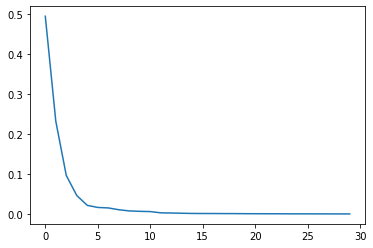

In [33]:
%%time
from sklearn.preprocessing import minmax_scale

for col in mas_v:
    df[col] = df[col].fillna(df[col].min() - 2) # -2 하는 이유는?
    df[col] = minmax_scale(df[col], feature_range=(0, 1))
    
df = PCA_change(df, mas_v, prefix="PCA_V_", n_components=30)

In [34]:
# 사실 30개까지 안해도 될듯
df = reduce_mem_usage(df)
# nan value들 때문에 오류 발생. 커널은 어떻게 괜찮은지??

C:\Users\ejesu\.conda\envs\test\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning:

invalid value encountered in less

C:\Users\ejesu\.conda\envs\test\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning:

invalid value encountered in less



Mem. usage decreased to 272.06 Mb (61.2% reduction)


### Setting train and test back

In [35]:
df_train, df_test = df[df['isFraud'] != 'test'], df[df['isFraud'] == 'test'].drop(
'isFraud', axis=1)

In [38]:
print(df_train.shape) # 정규화 과정에서 한 과정 합쳤기 때문에 하나 부족
print(df_test.shape)

(590540, 134)
(506691, 133)


### Setting X and y

In [40]:
X_train = df_train.sort_values('TransactionDT').drop([
    'isFraud', 'TransactionDT'
], axis=1)

y_train = df_train.sort_values('TransactionDT')['isFraud'].astype(bool)

X_test = df_test.sort_values('TransactionDT').drop(['TransactionDT'],
                                                  axis=1)

del df_train
df_test = df_test[['TransactionDT']] #label 위한 용도?

## HyperOpt 함수 정의

In [41]:
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score, make_scorer
from xgboost import plot_importance
import time

def objective(params):
    time1 = time.time()
    params = {
        'max_depth': int(params['max_depth']),
        'gamma': "{:.3f}".format(params['gamma']),
        'subsample': "{:.2f}".format(params['subsample']),
        'reg_alpha': "{:.3f}".format(params['reg_alpha']),
        'reg_lambda': "{:.3f}".format(params['reg_lambda']),
        'learning_rate': "{:.3f}".format(params['learning_rate']),
        'num_leaves': '{:.3f}'.format(params['num_leaves']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'min_child_samples': '{:.3f}'.format(params['min_child_samples']),
        'feature_fraction': '{:.3f}'.format(params['feature_fraction']),
        'bagging_fraction': '{:.3f}'.format(params['bagging_fraction'])
    }

    print("\n############## New Run ################")
    print(f"params = {params}")
    FOLDS = 7
    count=1
    skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=42)

    tss = TimeSeriesSplit(n_splits=FOLDS)
    y_preds = np.zeros(sample_submission.shape[0])
    y_oof = np.zeros(X_train.shape[0])
    score_mean = 0
    for tr_idx, val_idx in tss.split(X_train, y_train):
        clf = xgb.XGBClassifier(
            n_estimators=600, random_state=4, verbose=True, 
            tree_method='gpu_hist', 
            **params
        )

        X_tr, X_vl = X_train.iloc[tr_idx, :], X_train.iloc[val_idx, :]
        y_tr, y_vl = y_train.iloc[tr_idx], y_train.iloc[val_idx]
        
        clf.fit(X_tr, y_tr)
        #y_pred_train = clf.predict_proba(X_vl)[:,1]
        #print(y_pred_train)
        score = make_scorer(roc_auc_score, needs_proba=True)(clf, X_vl, y_vl)
        # plt.show()
        score_mean += score
        print(f'{count} CV - score: {round(score, 4)}')
        count += 1
    time2 = time.time() - time1
    print(f"Total Time Run: {round(time2 / 60,2)}")
    gc.collect()
    print(f'Mean ROC_AUC: {score_mean / FOLDS}')
    del X_tr, X_vl, y_tr, y_vl, clf, score
    return -(score_mean / FOLDS)


space = {
    # The maximum depth of a tree, same as GBM.
    # Used to control over-fitting as higher depth will allow model 
    # to learn relations very specific to a particular sample.
    # Should be tuned using CV.
    # Typical values: 3-10
    'max_depth': hp.quniform('max_depth', 7, 23, 1),
    
    # reg_alpha: L1 regularization term. L1 regularization encourages sparsity 
    # (meaning pulling weights to 0). It can be more useful when the objective
    # is logistic regression since you might need help with feature selection.
    'reg_alpha':  hp.uniform('reg_alpha', 0.01, 0.4),
    
    # reg_lambda: L2 regularization term. L2 encourages smaller weights, this
    # approach can be more useful in tree-models where zeroing 
    # features might not make much sense.
    'reg_lambda': hp.uniform('reg_lambda', 0.01, .4),
    
    # eta: Analogous to learning rate in GBM
    # Makes the model more robust by shrinking the weights on each step
    # Typical final values to be used: 0.01-0.2
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    
    # colsample_bytree: Similar to max_features in GBM. Denotes the 
    # fraction of columns to be randomly samples for each tree.
    # Typical values: 0.5-1
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, .9),
    
    # A node is split only when the resulting split gives a positive
    # reduction in the loss function. Gamma specifies the 
    # minimum loss reduction required to make a split.
    # Makes the algorithm conservative. The values can vary depending on the loss function and should be tuned.
    'gamma': hp.uniform('gamma', 0.01, .7),
    
    # more increases accuracy, but may lead to overfitting.
    # num_leaves: the number of leaf nodes to use. Having a large number 
    # of leaves will improve accuracy, but will also lead to overfitting.
    'num_leaves': hp.choice('num_leaves', list(range(20, 250, 10))),
    
    # specifies the minimum samples per leaf node.
    # the minimum number of samples (data) to group into a leaf. 
    # The parameter can greatly assist with overfitting: larger sample
    # sizes per leaf will reduce overfitting (but may lead to under-fitting).
    'min_child_samples': hp.choice('min_child_samples', list(range(100, 250, 10))),
    
    # subsample: represents a fraction of the rows (observations) to be 
    # considered when building each subtree. Tianqi Chen and Carlos Guestrin
    # in their paper A Scalable Tree Boosting System recommend 
    'subsample': hp.choice('subsample', [0.2, 0.4, 0.5, 0.6, 0.7, .8, .9]),
    
    # randomly select a fraction of the features.
    # feature_fraction: controls the subsampling of features used
    # for training (as opposed to subsampling the actual training data in 
    # the case of bagging). Smaller fractions reduce overfitting.
    'feature_fraction': hp.uniform('feature_fraction', 0.4, .8),
    
    # randomly bag or subsample training data.
    'bagging_fraction': hp.uniform('bagging_fraction', 0.4, .9)
    
    # bagging_fraction and bagging_freq: enables bagging (subsampling) 
    # of the training data. Both values need to be set for bagging to be used.
    # The frequency controls how often (iteration) bagging is used. Smaller
    # fractions and frequencies reduce overfitting.
}

## Running the optimizer

In [43]:
sample_submission = pd.read_csv("../input/sample_submission.csv",
                               index_col = 'TransactionID')

# set algorithm parameters
best = fmin(fn=objective, space=space, algo=tpe.suggest,
           max_evals=27)

# print best parameters
best_params = space_eval(space, best)

                                                                               
############## New Run ################
params = {'max_depth': 7, 'gamma': '0.306', 'subsample': '0.60', 'reg_alpha': '0.291', 'reg_lambda': '0.311', 'learning_rate': '0.189', 'num_leaves': '160.000', 'colsample_bytree': '0.524', 'min_child_samples': '230.000', 'feature_fraction': '0.628', 'bagging_fraction': '0.786'}
  0%|                                     | 0/27 [00:00<?, ?it/s, best loss: ?]


XGBoostError: [02:08:16] C:/Jenkins/workspace/xgboost-win64_release_0.90/src/tree/updater_gpu_hist.cu:1407: Exception in gpu_hist: [02:08:16] c:\jenkins\workspace\xgboost-win64_release_0.90\src\common\device_helpers.cuh:860: Check failed: device_ordinals.size() == 1 (0 vs. 1) : XGBoost must be compiled with NCCL to use more than one GPU.
